# Определение возраста покупателей

## Исследовательский анализ данных

С целью анализа покупок и контроля кассиров при продаже алкоголя, сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий посетителей. Нужно построить модель, которая по изображению определит приблизительный возраст покупателя. У нас имеется набор фотографий людей с указанием возраста, данные взяты с сайта ChaLearn Looking at People.

**Цель проекта**

На основе имеющихся изображений лиц обучить модель определять примерный возраст клиентов.

**Задачи проекта**

1.	Провести исследовательский анализ набора фотографий, изучить распределение по возрасту в выборке.
2.	Подготовить данные к обучению.
3.	Обучить нейронную сеть на изображениях, проверить её качество с помощью значения MAE (оно не должно быть больше 8).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Загрузим датафрейм с целевым признаком (реальным возрастом) и выведем по нему основную информацию.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.head(10))
print(labels.info())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


В таблице всего 2 колонки с номером фотографии и реальным возрастом изображенного на ней человека. Всего в наборе данных 7591 пример. Посмотрим, как разбросан наш целевой признак (real_age).

In [3]:
display(labels.describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В наборе данных преобладают люди молодого возраста, медианное значение - 29 лет. Минимальный возраст - 1 год, максимальный - 100 лет. Аномальных значений не обнаружено.

Построим график распределения возраста в выборке.

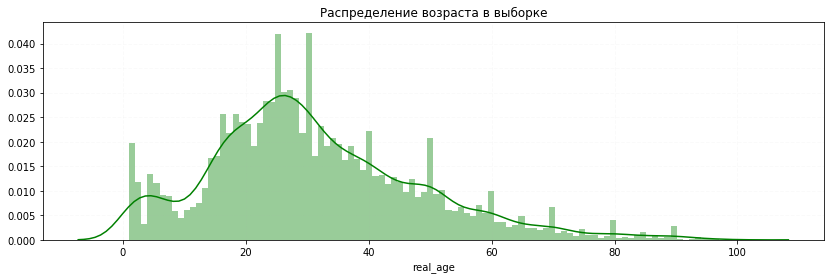

In [4]:
plt.figure(figsize=(14,4))
ax = sns.distplot(labels['real_age'], bins=100, color='green')
ax.set(title='Распределение возраста в выборке')
ax.grid(alpha=0.05, linestyle='--', linewidth=1)

Распределение выглядит не совсем нормальным. В датасете представлено большое количество малолетних детей (они не являются целевой аудиторией). Поэтому медианное значение смещено влево, в сторону более молодого возраста. Обратим внимание, что в распределении присутствуют пики 25, 30 лет и далее каждые 10 лет. Очень может быть, что изначально не все данные были размечены, и у части фотографий возраст проставлялся приблизительный.

Загрузим часть фотографий для просмотра.

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

faces_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


Для понимания, как устроен датасет, выведем одну фотографию, а затем несколько штук сразу.

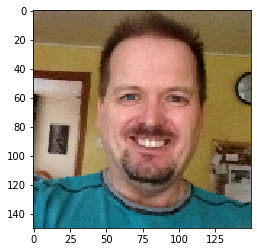

In [6]:
plt.imshow(faces_datagen_flow[0][0][0])

Посмотрим на небольшую часть набора фотографий - выведем 15 изображений. В заголовке каждого изображения укажем возраст из таблицы labels.

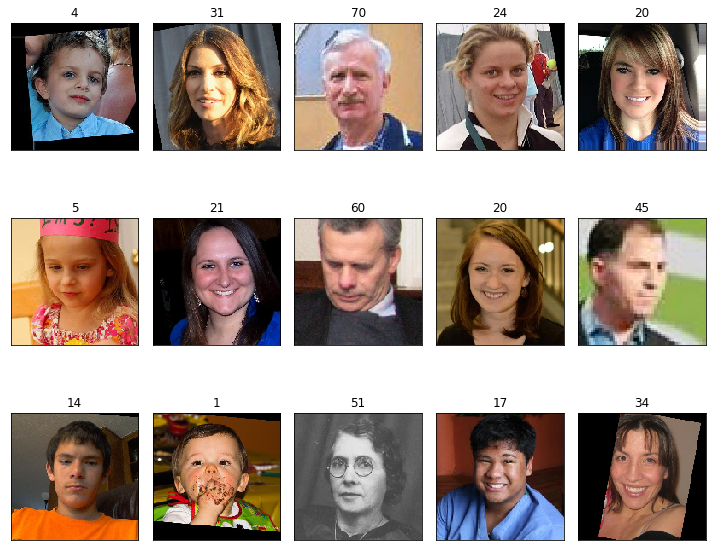

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    image, label = faces_datagen_flow.next()
    plt.title(label[i])
    plt.imshow(image[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В папке с фотографиями представлены снимки самого разного качества (размера, цвета, положения лиц на снимке).

### Вывод

В датасете собрано 7591 изображение. Из плюсов - фотографии разные, отличаются по положению лица на снимке, цвету, добавлены также черно-белые карточки. Присутствуют снимки как в профиль, так и в анфас. Из минусов -  большое количество фотографий маленьких детей. Поскольку они не являются людьми, непосредственно совершающими покупки, возможно, эта информация является лишней и может внести искажения в модель. К тому же после разбиения датасета на обучающую и валидационную выборки останется не так много фотографий подростков и взрослых для тренировки модели. Вероятно, здесь будет полезным добавление аугментации. Отметим также, что в распределении снимков по возрасту после 25 лет заметны пики с разницей примерно в 10 лет. Это значит, что возраст многих людей на фотокарточках может быть приблизительным, а не реальным.

## Обучение модели

Для определения возраста покупателей воспользуемся нейросетью с архитектурой ResNet (50 слоев), предобученной на датасете ImageNet. Чтобы модель обучалась быстрее, в аргументе weights укажем путь к файлу с весами.
Размер входного изображения - (150, 150, 3), последние слои добавим самостоятельно. В качестве алгоритма оптимизации укажем Adam (значение learning_rate по умолчанию). Модель обучается на трех эпохах.
Функция потерь - mean_squared_error, в качестве метрики качества модели выбрана MAE. Значение ошибки на тестовой выборке должно быть не больше 8.

```python
def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=str(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')    
    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    val_datagen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=str(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return val_datagen_flow


def create_model(input_shape):
    optim = Adam()
    backbone = ResNet50(input_shape=(150, 150, 3),
                 include_top=False,
                   weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu')) 
    
    model.compile(loss='mean_squared_error', metrics=['mae'], optimizer=optim)

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 116s - loss: 251.9309 - mae: 12.1004 - val_loss: 281.8278 - val_mae: 12.8287
Epoch 2/3
356/356 - 36s - loss: 180.9852 - mae: 10.4026 - val_loss: 301.6506 - val_mae: 12.8319
Epoch 3/3
356/356 - 36s - loss: 146.2788 - mae: 9.2460 - val_loss: 168.9033 - val_mae: 9.9016
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 168.9033 - mae: 9.9016
Test MAE: 9.9016
```

Ошибка очень высокая, качество модели нам не подходит. Попробуем добавить полносвязный слой с 50 нейронами и уменьшить learning rate в алгоритме Adam до 0.0001.

```
Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 121s - loss: 217.2968 - mae: 10.7938 - val_loss: 620.3001 - val_mae: 19.8470
Epoch 2/3
356/356 - 36s - loss: 65.2058 - mae: 6.2234 - val_loss: 152.9680 - val_mae: 9.3353
Epoch 3/3
356/356 - 36s - loss: 32.2860 - mae: 4.3998 - val_loss: 79.7113 - val_mae: 6.7307
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 79.7113 - mae: 6.7307
Test MAE: 6.7307
```

Качество модели заметно улучшилось. Посмотрим, есть ли возможность сделать его еще выше. Попробуем добавить аугментацию в модель: отразим фотографии по горизонтали.

```
Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 132s - loss: 223.1701 - mae: 10.9390 - val_loss: 715.3452 - val_mae: 21.7932
Epoch 2/3
356/356 - 36s - loss: 85.9591 - mae: 7.0576 - val_loss: 131.9100 - val_mae: 8.6783
Epoch 3/3
356/356 - 36s - loss: 58.0918 - mae: 5.8388 - val_loss: 108.1862 - val_mae: 7.6442
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 108.1862 - mae: 7.6442
Test MAE: 7.6442
```

Отражение фотографий эффективность модели только снизило. Уберем аугментацию и добавим количество эпох.

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 43s - loss: 222.8887 - mae: 11.0282 - val_loss: 390.8283 - val_mae: 14.7281
Epoch 2/5
356/356 - 35s - loss: 67.5320 - mae: 6.3331 - val_loss: 147.4268 - val_mae: 9.3108
Epoch 3/5
356/356 - 35s - loss: 34.6549 - mae: 4.5553 - val_loss: 108.2797 - val_mae: 7.6898
Epoch 4/5
356/356 - 35s - loss: 21.3470 - mae: 3.5437 - val_loss: 114.5564 - val_mae: 7.8634
Epoch 5/5
356/356 - 35s - loss: 15.8159 - mae: 3.0006 - val_loss: 77.3068 - val_mae: 6.6161
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 77.3068 - mae: 6.6161
Test MAE: 6.6161
```

Добавление эпох способствует более точному прогнозированию. Попробуем заморозить нашу модель без верхушки. Для ускорения обучения вернем назад 3 эпохи.

```
Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 136s - loss: 383.4113 - mae: 14.9805 - val_loss: 930.6712 - val_mae: 25.6980
Epoch 2/3
356/356 - 34s - loss: 276.1362 - mae: 12.8244 - val_loss: 870.9790 - val_mae: 24.6429
Epoch 3/3
356/356 - 34s - loss: 248.9511 - mae: 12.1721 - val_loss: 835.4707 - val_mae: 24.0099
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 835.4707 - mae: 24.0099
Test MAE: 24.0099
```

Это худшее значение MAE, которое мы получили.

Итоговый код (с тремя эпохами) для лучшей модели (с MAE=6.73) выглядит так. Для повышения качества количество эпох можно добавить.

```python
def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=str(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')    
    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    val_datagen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=str(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return val_datagen_flow


def create_model(input_shape):
    optim = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(150, 150, 3),
                 include_top=False,
                 weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1, activation='relu')) 
    
    model.compile(loss='mean_squared_error', metrics=['mae'], optimizer=optim)

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

### Вывод

Из всех вариантов доработок сети ResNet50 лучший результат выдала модель с дополнительным полносвязным слоем с 50 нейронами и алгоритмом оптимизации Adam (learning_rate=0.0001).

## Анализ обученной модели, общий вывод

С целью определения возраста по фотографиям было проанализировано 7591 изображение самых разных людей. 
Для решения задачи применена нейросеть ResNet50 без верхушки, предобученная на наборе данных ImageNet. Последние слои добавлялись отдельно. Минимальное значение средней абсолютной ошибки получилось при добавлении полносвязного слоя с 50 нейронами, алгоритме оптимизации Adam (learning_rate=0.0001), без аугментации и без заморозки костяка ResNet50. Такая модель продемонстрировала МАЕ=6.73 при трех эпохах и MAE=6.62 при 5 эпохах.

Условно говоря, оценки возраста моделью могут расходиться с реальностью на 6-7 лет. Но здесь нужно вспомнить о количестве людей разных возрастов и о том, что в датасете много маленьких детей. Будет полезно изучить, как определяется возраст для этих разных групп. Возможно, модель хорошо отличает детей 1-3 лет, но плохо выявляет возраст остальных. Т.е. отличить подростка от годовалого малыша довольно просто, а вот подростка от молодого человека или 25-летнего от 35-летнего может быть гораздо сложнее.